In [1]:
%cd /content
!git clone https://github.com/xiaochus/MobileNetV3
%cd /content/MobileNetV3

/content
fatal: destination path 'MobileNetV3' already exists and is not an empty directory.
/content/MobileNetV3


In [2]:
from model.mobilenet_v3_small import MobileNetV3_Small
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.applications import MobileNetV2

def data():
    # dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    X_train = x_train.astype('float32') / 255
    X_test = x_test.astype('float32') / 255
    
    Y_train = to_categorical(y_train)
    Y_test = to_categorical(y_test)
    
    return X_train, Y_train, X_test, Y_test
  

def train_V3(epochs, alpha):
    X_train, Y_train, X_test, Y_test = data()
    
    shape = (32, 32, 3)
    classes = 10

    model = MobileNetV3_Small(shape, classes, alpha).build()

    opt = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Data Augmentation
    datagen = ImageDataGenerator(rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True)

    #cnnの学習
    start = time.time()

    hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=1024),
                               steps_per_epoch=len(X_train) / 1024,
                               validation_data=(X_test, Y_test),
                               verbose = False,
                               epochs=epochs)
    
    result_time = time.time() - start
    
    return model, hist, result_time
  
def train_V2(epochs, alpha):
    X_train, Y_train, X_test, Y_test = data()
  
    shape = (32, 32, 3)
    classes = 10

    model = MobileNetV2(include_top=True, input_shape=shape, alpha=alpha, weights=None)
    
    # 最終層削除
    model.layers.pop()
    model = Model(inputs=model.input,outputs=model.layers[-1].output)
    
    # L2層と全結合層を付ける
    c = Dense(classes, activation='softmax')(model.output)
    model = Model(inputs=model.input,outputs=c)


    opt = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Data Augmentation
    datagen = ImageDataGenerator(rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True)

    #cnnの学習
    start = time.time()

    hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=1024),
                               steps_per_epoch=len(X_train) / 1024,
                               validation_data=(X_test, Y_test),
                               verbose = False,
                               epochs=epochs)
    
    result_time = time.time() - start
    
    return model, hist, result_time
  
def predict_time(model):
    result = []

    for i in range(1000):
        start = time.time()
        model.predict(np.zeros((1,32,32,3)))
        result.append(time.time() - start)
    
    return result

Using TensorFlow backend.


#推論時間

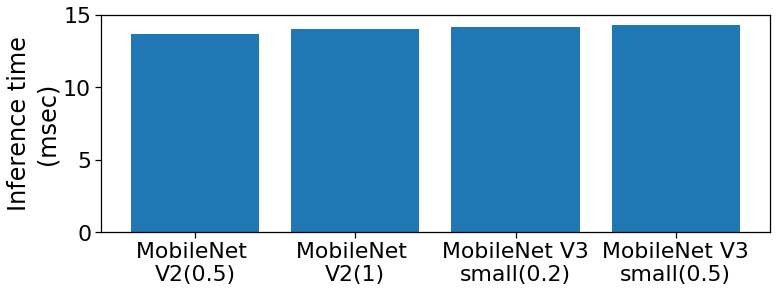

In [0]:
v2_small, _, _ = train_V2(1, 0.5)
v2, _, _ = train_V2(1, 1)
v3_small, _, _ = train_V3(1, 0.2)
v3, _, _ = train_V3(1, 0.5)

v3_time = np.array(predict_time(v3))*1000
v3_small_time = np.array(predict_time(v3_small))*1000
v2_time = np.array(predict_time(v2))*1000
v2_small_time = np.array(predict_time(v2_small))*1000

label = ["MobileNet \nV2(0.5)","MobileNet \nV2(1)","MobileNet V3\nsmall(0.2)","MobileNet V3\nsmall(0.5)"]
result = [np.mean(v2_small_time), np.mean(v2_time), np.mean(v3_small_time), np.mean(v3_time)]
sns.set_context("notebook",font_scale=2)
plt.figure(figsize=(12,4))
plt.bar(label, result)
plt.ylabel("Inference time\n(msec)")
plt.show()

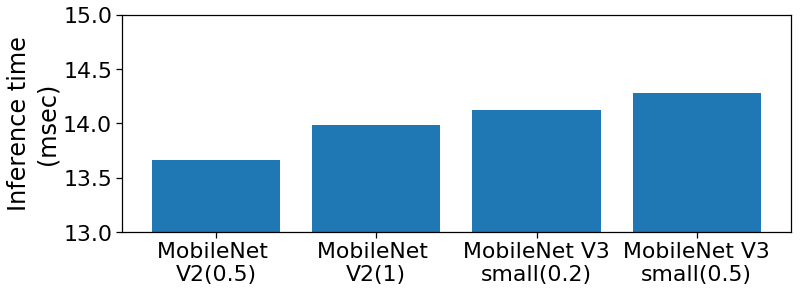

In [0]:
label = ["MobileNet \nV2(0.5)","MobileNet \nV2(1)","MobileNet V3\nsmall(0.2)","MobileNet V3\nsmall(0.5)"]
result = [np.mean(v2_small_time), np.mean(v2_time), np.mean(v3_small_time), np.mean(v3_time)]
sns.set_context("notebook",font_scale=2)
plt.figure(figsize=(12,4))
plt.bar(label, result)
plt.ylabel("Inference time\n(msec)")
plt.ylim(13,15)
plt.show()

#重みのサイズ

In [0]:
v2_small.save_weights('v2_small.h5')
v2.save_weights('v2.h5')
v3_small.save_weights('v3_small.h5')
v3.save_weights('v3.h5')

In [0]:
ls -lS

total 34976
-rw-r--r-- 1 root root 11761904 Jul 23 05:29 v3.h5
-rw-r--r-- 1 root root 11285912 Jul 23 05:28 v3_small.h5
-rw-r--r-- 1 root root  9466096 Jul 23 05:27 v2.h5
-rw-r--r-- 1 root root  3260656 Jul 23 05:26 v2_small.h5
drwxr-xr-x 2 root root     4096 Jul 23 05:21 config/
drwxr-xr-x 2 root root     4096 Jul 23 05:21 images/
drwxr-xr-x 4 root root     4096 Jul 23 05:21 model/
-rw-r--r-- 1 root root     3156 Jul 23 05:21 train_cls.py
-rw-r--r-- 1 root root     1172 Jul 23 05:21 README.md
-rw-r--r-- 1 root root     1062 Jul 23 05:21 LICENSE


#学習時間、精度

In [0]:
print("v2(0.5)")
_, hist, time_ = train_V2(100, 0.5)
acc = np.max(hist.history["val_acc"])
print("val_acc", acc)
print("time(epoch100)", time_)

In [0]:
print("v2(1)")
_, hist, time_ = train_V2(100, 1)
acc = np.max(hist.history["val_acc"])
print("val_acc", acc)
print("time(epoch100)", time_)

In [0]:
print("v3(0.2)")
_, hist, time_ = train_V3(100, 0.2)
acc = np.max(hist.history["val_acc"])
print("val_acc", acc)
print("time(epoch100)", time_)

In [0]:
print("v3(0.5)")
_, hist, time_ = train_V3(100, 0.5)
acc = np.max(hist.history["val_acc"])
print("val_acc", acc)
print("time(epoch100)", time_)

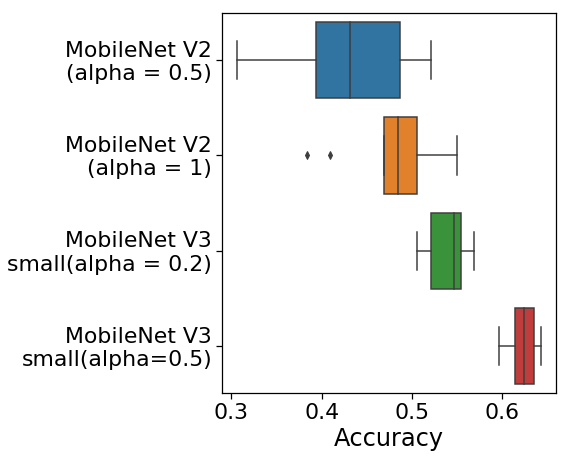

In [0]:
v2_small_acc = [0.5068, 0.4105, 0.5211, 0.3914, 0.4519, 0.3061, 0.4618, 0.3107, 0.4946, 0.4022]
v2_acc = [0.4695, 0.4089, 0.4686, 0.5503, 0.3838, 0.4817, 0.5499, 0.5005, 0.5078, 0.4876]
v3_small_acc = [0.5157, 0.5688, 0.5139, 0.5061, 0.5511, 0.5467, 0.5659, 0.5549, 0.5472, 0.5369]
v3_acc = [0.6362, 0.5961, 0.6106, 0.6240, 0.6431, 0.6302, 0.6086, 0.6247, 0.6234, 0.6419]

plt.figure(figsize=(6,7))
sns.set_context("notebook",font_scale=2)
sns.boxplot(x=[v2_small_acc, v2_acc, v3_small_acc, v3_acc], 
            y=["MobileNet V2\n(alpha = 0.5)","MobileNet V2\n(alpha = 1)", "MobileNet V3\nsmall(alpha = 0.2)", "MobileNet V3\nsmall(alpha=0.5)"])
plt.xlabel("Accuracy")
plt.show()